In [2]:
import json
import requests
import numpy as np
import os, sys
from collections import Counter, defaultdict
import math
import datetime


In [3]:
print(os.getcwd())
sys.path.insert(0, str(os.path.dirname(os.path.realpath(os.getcwd()))))
print(sys.path)

/mnt/f/dev/git/miRExplore/python/nbs
['/mnt/f/dev/git/miRExplore/python', '/mnt/f/dev/git/miRExplore/python/nbs', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/mjoppich/.local/lib/python3.8/site-packages', '/home/mjoppich/.local/lib/python3.8/site-packages/pIMZ-1.0-py3.8-linux-x86_64.egg', '/home/mjoppich/.local/lib/python3.8/site-packages/progressbar-2.5-py3.8.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/mpld3-0.3.1.dev1-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/mpl_chord_diagram-0.3.0-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython']


In [4]:
from textdb.PubmedDateDB import PubmedDateDB
from synonymes.mirnaID import miRNA, miRNAPART,miRNACOMPARISONLEVEL
from textdb.MiGenRelDB import MiGenRelDB

from synonymes.GeneOntology import GeneOntology

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests



In [5]:
def getPMIDInfo(jsonRes, infodict, pmid, infodict2obo={}):
    
    diseaseInfos = jsonRes["pmidinfo"][infodict].get(pmid, [])
    diseaseInfo = ""
        
    infoObo = infodict2obo.get(infodict, None)
    
    ignoreTerms = None
    #if infodict == "cells":
    #    ignoreTerms = []
    #    
    #    for ignoreTerm in ["META:3", "META:707", "EFO:0000408", "META:403", "EFO:0000408", "BFO:0000017"]:
    #        ignoreTerms += [x.termid for x in infoObo[ignoreTerm].getAllChildren()]

    allFoundTerms = set()
    termid2termname = {}
    allDiseaseInfos = Counter()
    for di in diseaseInfos:
        dit = di.get("termname", None)
        diid = di.get("termid", None)
        
        #print(di["termid"], dit)
        
        if dit in ["cell", "disease", "cells", "protein", "data item", "role", "signaling", "immune response"]:
            continue
            
        if infodict == "cells" and diid != None and diid.startswith(("CHEBI", "PR", "DOID", "UBERON", "IAO")):
            continue
        
        if diid != None:
            allFoundTerms.add(diid)
            termid2termname[diid] = dit
            
        
        for diid in allFoundTerms:
            
            if infoObo != None:
                oboterm = infodict2obo[infodict][diid]
                
                if oboterm != None:
                    allchildren = [x.termid for x in oboterm.getAllChildren()]
                    allparents = [x.id for x in oboterm.getAllParents()]
                    
                    childIntersect = set(allchildren).intersection(allFoundTerms)
                    parentIntersect = set(allparents).intersection(allFoundTerms)

                    if (len(parentIntersect)>0) or (ignoreTerms != None and diid in ignoreTerms):
                        
                        igTerm = ignoreTerms != None and diid in ignoreTerms
                        
                        #print("skipping", diid, termid2termname[diid], len(parentIntersect), igTerm)
                        continue
                        
                    if len(childIntersect)> 0:
                        for x in childIntersect:
                            
                            if termid2termname[x] in allDiseaseInfos:
                                del allDiseaseInfos[termid2termname[x]]
                            #print("removing", termid2termname[x])
                        
        
            dit = termid2termname[diid]
            allFoundTerms.add(diid)
            
            allDiseaseInfos[dit] += 1

    allDiseaseInfos = [x[0] for x in allDiseaseInfos.most_common(4)]
    
    diseaseInfo = ""
    xlen = 20
    for xi, x in enumerate(allDiseaseInfos):
        

        
        if len(diseaseInfo) + len(x) > xlen:
            if xi > 0:
                diseaseInfo += ";"
            
            diseaseInfo += "\n" + x
            
            xlen += 20
                        
                
        else:
            if xi > 0:
                diseaseInfo += "; "
                
            diseaseInfo += x
            
            
                
    return diseaseInfo
    


In [13]:
def make_timeline( allInteractions, title, outpath=None ):

    allInteractions = sorted(allInteractions, key=lambda x: x[1])
    
    names = []
    dates = []

    for x in allInteractions:
        pmid = x[0] + "\n" + x[2] + "\n" + x[3] + "\n" + x[4]
        date = datetime.datetime.fromtimestamp(x[1])

        names.append(pmid)
        dates.append(date)
        
    alllevels = [-5,5,-1,1] #-3,3,
        
    # Choose some nice levels
    levels = np.tile(alllevels,
                     int(np.ceil(len(dates)/len(alllevels))))[:len(dates)]
    
    szFac = len(names) // 15
    szFac += 1

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(szFac * 15, 15), constrained_layout=True)
    ax.set(title=title)

    markerline, stemline, baseline = ax.stem(dates, levels,
                                             linefmt="C3-", basefmt="k-",
                                             use_line_collection=True)

    plt.setp(markerline, mec="k", mfc="w", zorder=3)

    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))

    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, ltext, va in zip(dates, levels, names, vert):
        ax.annotate(ltext, xy=(d, l+ (-1) * np.sign(l) * 0.75), xytext=(-10, np.sign(l)*4),
                    textcoords="offset points", va=va, ha="right")

    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.margins(y=0.1)
    
    #if outpath != None:
    #    plt.savefig(outpath)
    #plt.show()

In [7]:
def generateInteractionHistory( gene, mir, context=None, outfile=None, obodict={}, API_endpoint="http://localhost:65500"):
    
    if not gene is None:    
        requestDict = {"gene": [gene], "sentences": "false"}
    elif not mir is None:
        requestDict = {"mirna": [mir], "sentences": "false"}
        
    origGene = gene
    origMir = mir
        
    if not context is None:
        for x in context:
            requestDict[x] = context[x]

    r = requests.post("{}/find_interactions".format(API_endpoint), data=json.dumps(requestDict))
    jsonRes = r.json()
    
    all_pubs = set()
    
    targetMir = None
    if not mir is None:
        targetMir = miRNA(mir)
        
    doc2evidences = defaultdict( lambda: defaultdict(set))

    for x in jsonRes['rels']:
        for y in x["evidences"]:

            docID = y.get("docid", None)
            docDate = y.get("docdate", None)

            if docID == None or docDate == None:
                continue

            gene = y.get("lid", None)
            mirStr = y.get("rid", None)

            mirObj = miRNA(mirStr)
            
            if not targetMir is None:
                if not targetMir.accept(mirObj, miRNACOMPARISONLEVEL.PRECURSOR):
                    continue
            
            
            relInteract = y.get("rel_interaction", "MIR_GENE")
            relCategory = y.get("rel_category", "DOWN")
            
            e1 = gene
            e2 = mirStr          

            diseaseInfo = getPMIDInfo(jsonRes, "disease", docID, infodict2obo=obodict)
            cellInfo = getPMIDInfo(jsonRes, "cells", docID, infodict2obo=obodict)
            goInfo = getPMIDInfo(jsonRes, "go", docID, infodict2obo=obodict)
            doc2evidences[docID][(e1, e2)].add( (relInteract, relCategory) )

            all_pubs.add((docID, docDate, diseaseInfo, cellInfo, goInfo))
            
            
    all_pubs_print = set()
    
    for x in all_pubs:
        
        x = list(x)
        
        docID = x[0]
        
        for gene, mirStr in sorted(doc2evidences[docID]):
                    
            allEvs = doc2evidences[docID][(gene, mirStr)]
                            
            allInteracts = list(set([y[0] for y in allEvs]))
            allCats = list(set([y[1] for y in allEvs]))

            if len(allInteracts) != 1:
                e1 = mirStr
                e2 = gene   
                e12c = u"\u21ff"

            else:
                relInteract = allInteracts[0]

                if relInteract == "MIR_GENE":
                    e1 = mirStr
                    e2 = gene               
                else:
                    e1 = gene
                    e2 = mirStr

                relCategory = "NA"
                if len(allCats) == 1:
                    relCategory = allCats[0]

                if len(allCats)== 2 and "DOWN" in allCats and "NEU" in allCats:
                    relCategory = "NEU"            

                if relCategory in ["DOWN", "DOWN*"]:
                    e12c = u"\u22a3"
                elif relCategory in ["UP"]:
                    e12c = u"\u2191"
                elif relCategory in ["NEU"]:
                    e12c = u"\u21e5"
                elif relCategory in ["NA"]:
                    print(e1, e2,allInteracts,allCats)
                    print()
                    e12c = u"\u2974"
                    e12c = u"\u1e6a"

            xDocID = u"\n{} {} {}".format(e1, e12c, e2)
            x[0] += xDocID

        all_pubs_print.add(tuple(x))
            
    print("found results", len(all_pubs_print))
    
    if not origGene is None and not origMir is None:
        title = "{}-{} interactions".format(origGene, origMir)
        
    else:
        title="{} interactions".format(origGene if origMir is None else origMir)
    
    if len(all_pubs_print):
        make_timeline( all_pubs_print, title, outpath=outfile )
    



In [8]:
oboFolder = "/mnt/w/miRExplore_pmid_pmc/obodir/"

infodict2obo = {}
infodict2obo["cells"] = GeneOntology(oboFolder + "/cell_ontology.obo")
infodict2obo["disease"] = GeneOntology(oboFolder + "/doid.obo")
infodict2obo["go"] = GeneOntology(oboFolder + "/go.obo")

0
no parent 164
0
10000
no parent 2459
0
10000
20000
30000
40000
no parent 3660


found results 3


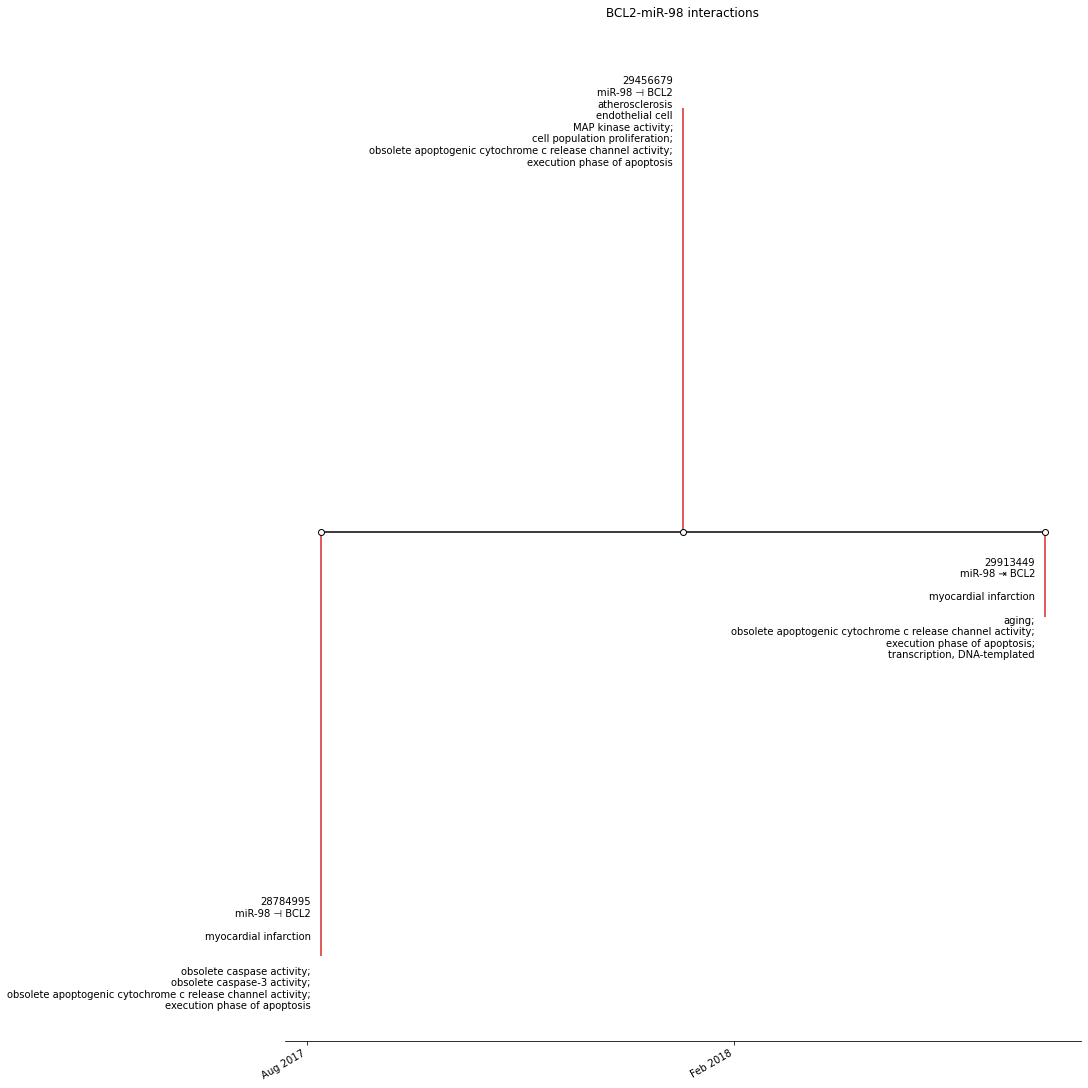

In [9]:
generateInteractionHistory(gene="BCL2", mir="miR-98", context={'disease': [{'termid': "DOID:1287"}]}, obodict=infodict2obo)

miR-155 CCL2 ['MIR_GENE'] ['UP', 'DOWN']

miR-33 CCL2 ['MIR_GENE'] ['UP', 'DOWN']

miR-493 CCL2 ['MIR_GENE'] ['UP', 'NEU']

miR-155 CCL2 ['MIR_GENE'] ['UP', 'NEU', 'DOWN']

found results 46


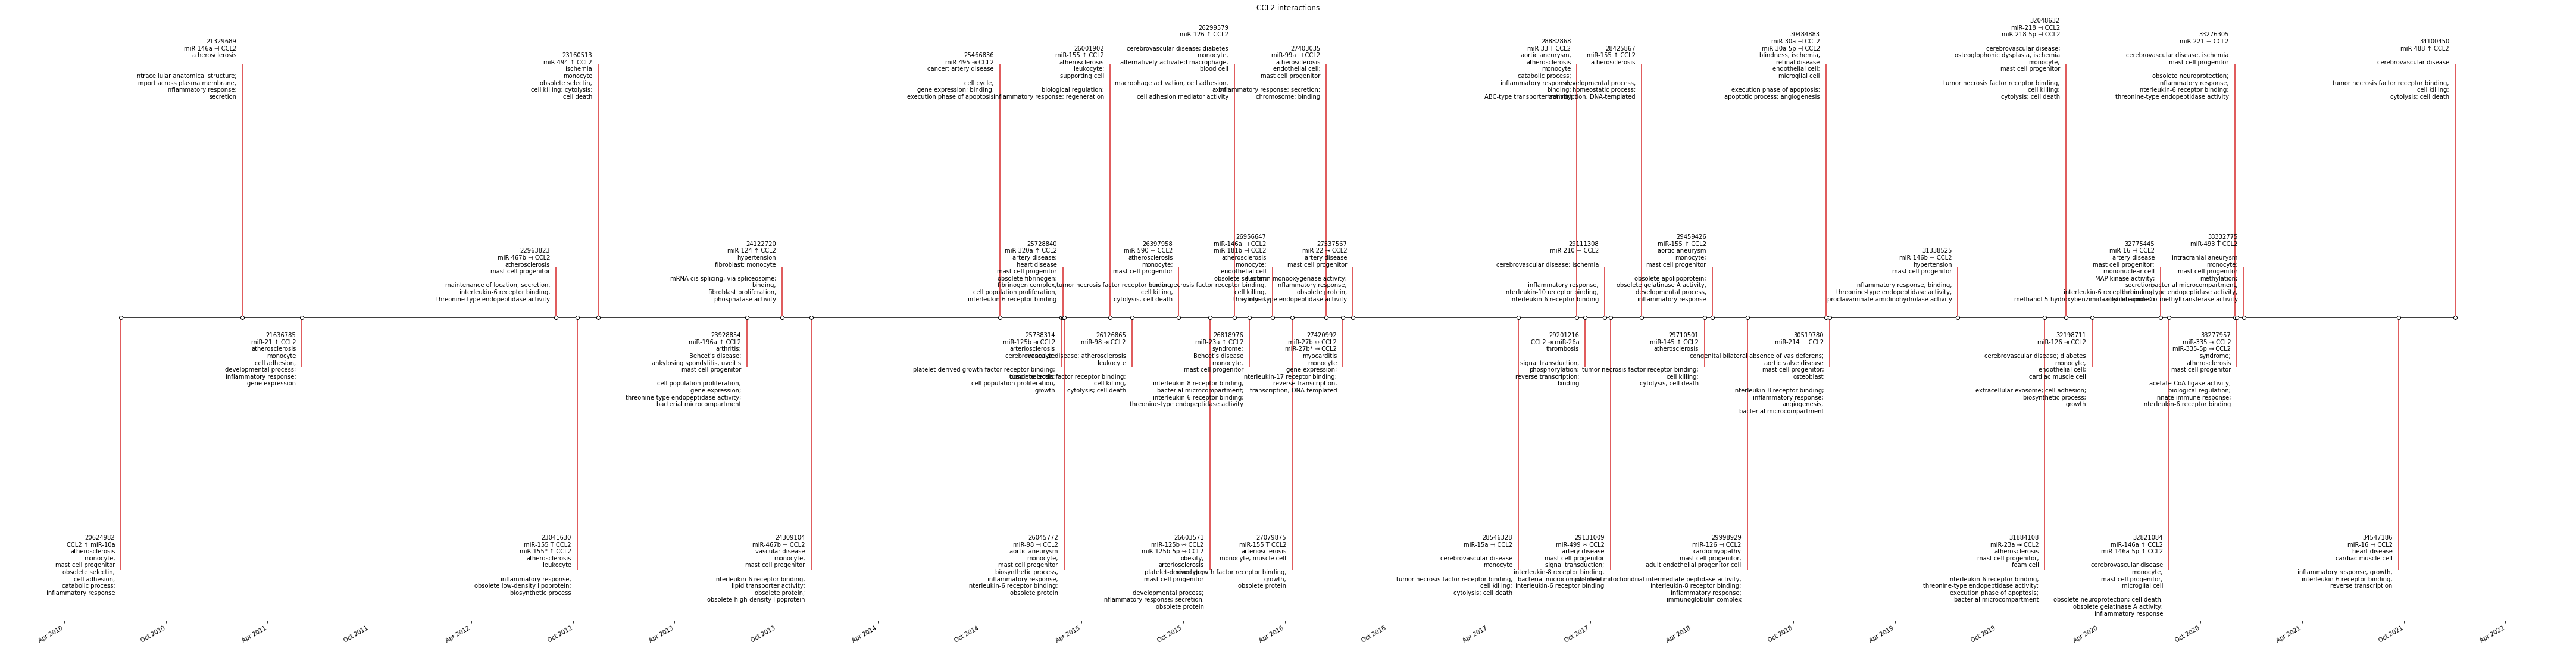

In [10]:
generateInteractionHistory(gene="CCL2", mir=None, context={'disease': [{'termid': "DOID:1287"}]}, obodict=infodict2obo)

miR-155 CCL2 ['MIR_GENE'] ['UP', 'NEU', 'DOWN']

miR-493 CCL2 ['MIR_GENE'] ['UP', 'NEU']

miR-33 CCL2 ['MIR_GENE'] ['UP', 'DOWN']

miR-155 CCL2 ['MIR_GENE'] ['UP', 'DOWN']

found results 46


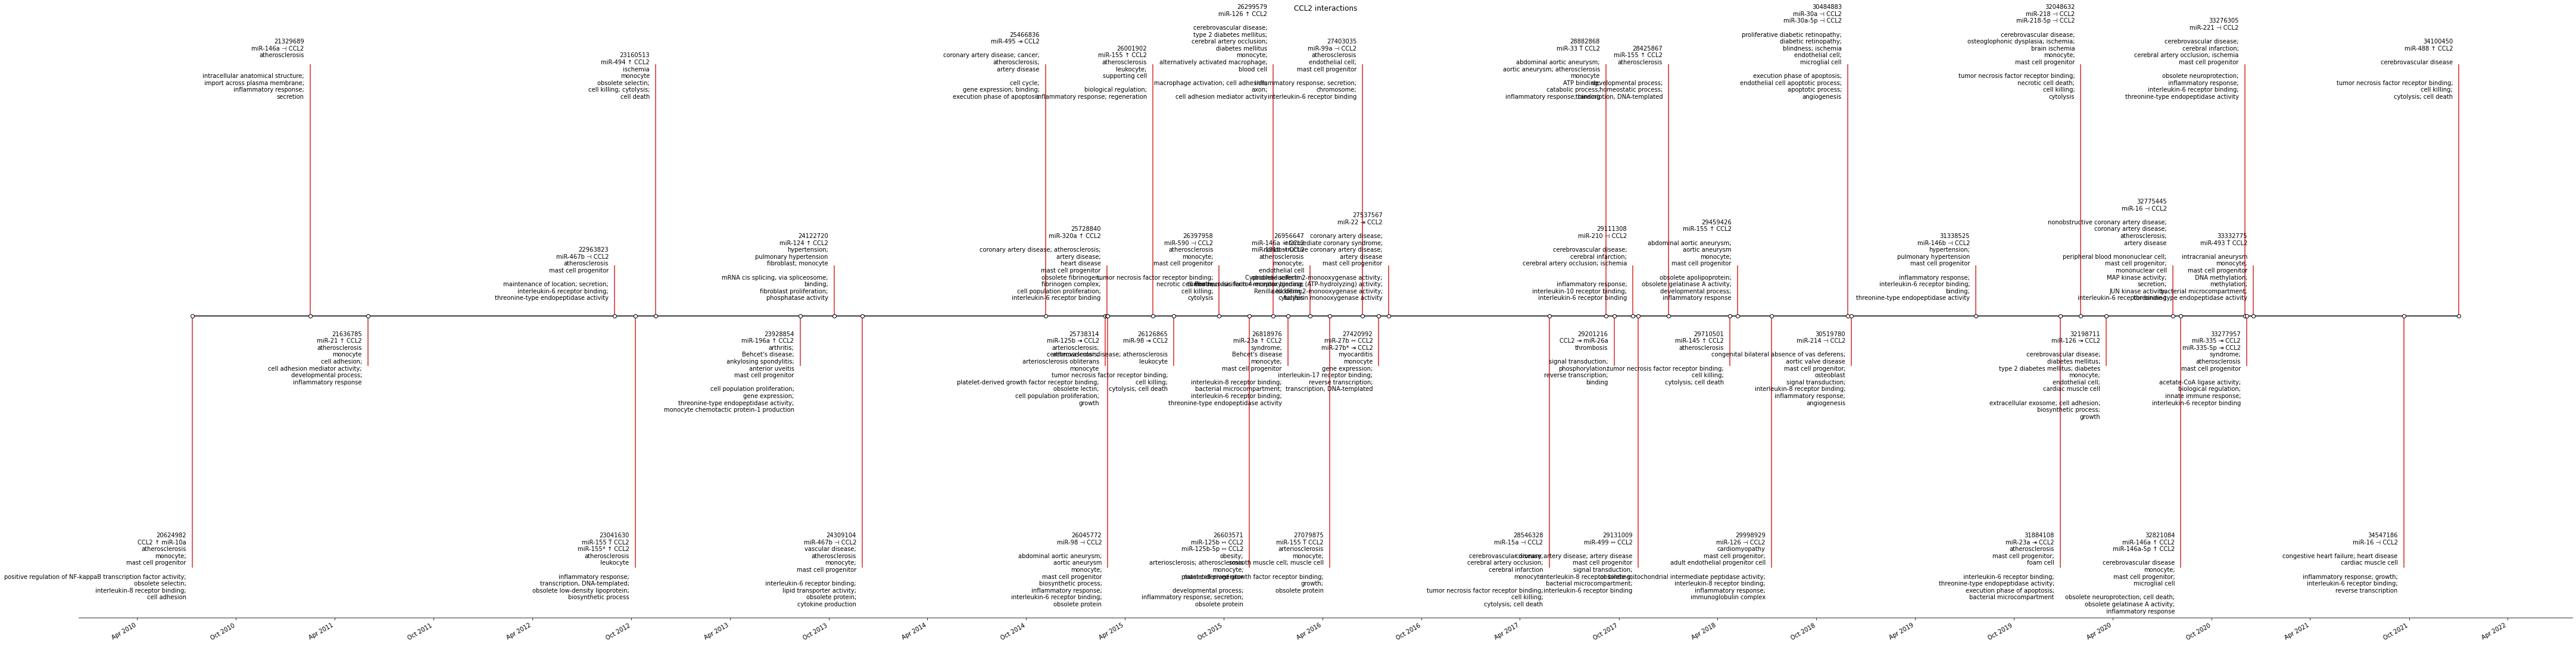

In [14]:
generateInteractionHistory(gene="CCL2", mir=None, context={'disease': [{'termid': "DOID:1287"}]})
plt.savefig("ccl2_athero.png")